# Data Mining Final Group Project

In [30]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats.contingency import crosstab
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.eval_measures import aic
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, r2_score
from sklearn.metrics import confusion_matrix, classification_report
import statsmodels.formula.api as smf

The following code loads the data, then drops rows with null values, cleans the data a bit to make mostly-numeric columns all numeric, and separates numerical from categorical variables for analysis and feature selection.

In [3]:
df = pd.read_csv("survey_results_public.csv")
print("Target rows with nulls:", df['Hobbyist'].isna().sum())            # relatively few nulls (45)
df = df.dropna(how='any', subset='Hobbyist')  # drop all rows in the response var col without values

print("Total Columns:", df.columns.size)

# categorical columns
cat_vars_cols = df.columns.drop(
                ['Hobbyist',
                 'Respondent', 
                 'Age', 
                 'Age1stCode',
                 'CompTotal', 
                 'ConvertedComp',
                 'WorkWeekHrs',
                 'YearsCode',
                 'YearsCodePro'])

# conversion to make these a quanititative var
df.replace(to_replace={'YearsCode': 'Less than 1 year'}, value=0.5, inplace=True)
df.replace(to_replace={'YearsCode': 'More than 50 years'}, value=55, inplace=True)
df.replace(to_replace={'YearsCodePro': 'Less than 1 year'}, value=0.5, inplace=True)
df.replace(to_replace={'YearsCodePro': 'More than 50 years'}, value=55, inplace=True)

# true values unlikely to be far from these replacements
df.replace(to_replace={'Age1stCode': 'Younger than 5 years'}, value=3, inplace=True)
df.replace(to_replace={'Age1stCode': 'Older than 85'}, value=87, inplace=True)

# quantitative columns
quant_vars_cols = pd.Index(
                  ['Age',
                   'Age1stCode',
                   'CompTotal',
                   'ConvertedComp',
                   'WorkWeekHrs',
                   'YearsCode',
                   'YearsCodePro'])

print("\nNumerical column null counts")
print(df[quant_vars_cols].isna().sum())

Target rows with nulls: 45
Total Columns: 61

Numerical column null counts
Age              18970
Age1stCode        6516
CompTotal        29590
ConvertedComp    29660
WorkWeekHrs      23265
YearsCode         6732
YearsCodePro     18067
dtype: int64


While our target variable has releatively few nulls, our numerical features have quite a lot. These will cause us problems in our regression fitting, so we don't have a choice but to drop those too. Even with that drop, though, we clearly still have almost 30,000 datapoints, which is still plenty to work with.

In [4]:
df.dropna(subset=quant_vars_cols, inplace=True)
print("Number of observations after drop:", df.shape[0])

# NaN's made the quantitative columns string types, so had to convert back to float
df[quant_vars_cols] = df[quant_vars_cols].astype(float)

Number of observations after drop: 29893


## Variable selection

61 columns is a lot of features! We obviously don't want this many. So, to slim down the features further, we can exclude categorical features with very high numbers of levels, since these won't really work well in a machine learning model. So let's see the number of unique values for each categorical feature:

### Categorical variable selection

In [5]:
# count number of levels on each categorical column, drop ones with high number of levels
# sorted for convenience
col_unique_counts = df[cat_vars_cols].nunique(dropna=True).sort_values(axis=0, ascending=True)
print(col_unique_counts)

MainBranch                         2
Trans                              2
NEWOtherComms                      2
CompFreq                           3
SurveyLength                       3
SurveyEase                         3
NEWOffTopic                        3
NEWOnboardGood                     3
SOAccount                          3
Employment                         3
PurchaseWhat                       3
NEWDevOps                          3
JobSeek                            3
NEWLearn                           4
OpSys                              4
NEWPurpleLink                      4
NEWOvertime                        5
NEWEdImpt                          5
JobSat                             5
NEWDevOpsImpt                      5
SOComm                             6
SOPartFreq                         6
SOVisitFreq                        6
WelcomeChange                      6
Gender                             7
EdLevel                            9
OrgSize                            9
U

Some of these variables have hundreds or even thousands of levels! Looks like we can drop about everything after `WelcomeChange`, as it has only 6 levels, and everything after has more.

In [6]:
# categorical variables with smaller number of levels up to the Sexuality column
cat_vars_cols = col_unique_counts.loc[:'WelcomeChange'].index
cat_vars_cols

Index(['MainBranch', 'Trans', 'NEWOtherComms', 'CompFreq', 'SurveyLength',
       'SurveyEase', 'NEWOffTopic', 'NEWOnboardGood', 'SOAccount',
       'Employment', 'PurchaseWhat', 'NEWDevOps', 'JobSeek', 'NEWLearn',
       'OpSys', 'NEWPurpleLink', 'NEWOvertime', 'NEWEdImpt', 'JobSat',
       'NEWDevOpsImpt', 'SOComm', 'SOPartFreq', 'SOVisitFreq',
       'WelcomeChange'],
      dtype='object')

Now we can compare each categorical variable against each other to see if which categorical variables are independent of which (if any). We'll be using $\chi ^2$ tests of independence here, the equivalent of multicolinearity tests for categorical variables. can only select variables that are indeendent of each other, or else we get multicollinearity in the model. Depending on the model, multicolinearity can result in anything from redundancy between features to misleading model results and violation of assumptions. So either way, we can use this test to eliminate features.

In [7]:
# this codeblock takes about 45s to run on my (slow) machine
# it simply conducts the tests and saves the results
num_cat_cols = len(cat_vars_cols)
chi_sq_tests = np.zeros((num_cat_cols, num_cat_cols))

for i, rows in enumerate(cat_vars_cols):
    for j, cols in enumerate(cat_vars_cols):

        row_levels = df[rows].unique()
        col_levels = df[cols].unique()
    
        ctab_result = crosstab(df[rows], df[cols],
                               levels=(
                                   row_levels[~pd.isnull(row_levels)],  # don't consider null as a level value
                                   col_levels[~pd.isnull(col_levels)]))
        
        # if there is a row or column of all zeros in the contingency table (ctab_result[1])
        # then mark the chi-squared test for that combo 0 

        # this is because of something called 'structural zeros', which come from a level of one variable 
        # being impossible to occur on any level of the compared variable, by definition 
        # (Martin checked the relevant combos). 

        # A row of structural zeros is something like with SOPartFrew ("How often do you participate 
        # on Stack Overflow account?") and SOVisitFreq ("How often do you visit Stack Overflow?"): 
        # the contingency table for these would have a row or column of zeros, since an option for 
        # SOVisitFreq is 'never, before today'. It wouldn't make sense to ask about participation frequency 
        # if the survey-taker had never visited! so that row is 0 by definition. 
        # Or at least, this seems to be the survey technique.

        # When structural zeros occur, there is no standard statistical method for dealing with them. 
        # Martin made the decision to mark the p-value for tests with rows of structural zeros as 0,
        # since these rows imply that there's some sort of relationship
        # source: https://www.quality-control-plan.com/StatGuide/conting_anal_ass_viol.htm#Structural%20zeroes


        # this conditions checks to make sure there is at least one non-zero value in each row/col
        if (np.any(ctab_result[1], axis=0).all() and np.any(ctab_result[1], axis=1).all()):
            test_results = stats.chi2_contingency(ctab_result[1])
            chi_sq_tests[i][j] = test_results[1]  # load p-values into the grid
        else:
            # # these commented-out will print the variables whose contingincy tables have 
            # # rows of structural zeros
            # print("\n", rows)
            # print("   Levels:", row_levels[~pd.isnull(row_levels)])
            # print(cols)
            # print("   Levels:", col_levels[~pd.isnull(col_levels)])
            # print(ctab_result[1], "\n")
            chi_sq_tests[i][j] = 0
            

        # this part prints the completion status
        amount_completed = 100*((num_cat_cols*i + j + 1)/num_cat_cols**2)
        print(" row:", i, 
              "col:", j, 
              "Progress: {:.2f}%".format(amount_completed),
              end="\r")  # progress

Now we can see our results. This code gives a chart of all the variables and how independent they are in terms of $\chi^2$ test $p$-values.

<Axes: >

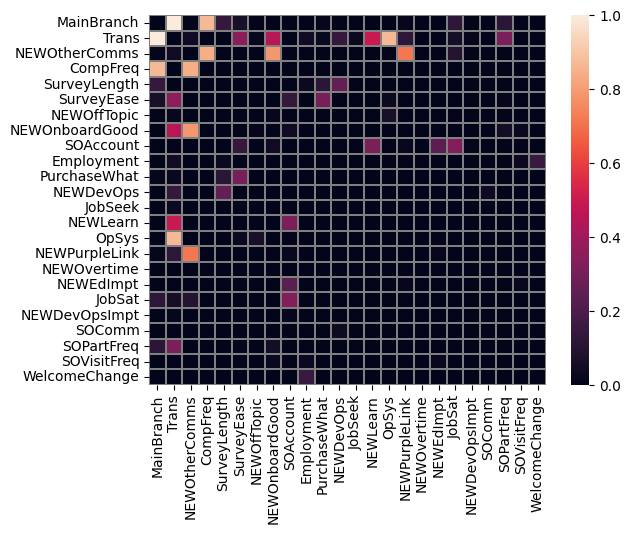

In [8]:
# redefine as a DataFrame, to have labels
chi_sq_tests = pd.DataFrame(chi_sq_tests, 
                            columns=cat_vars_cols, 
                            index=cat_vars_cols)
round(chi_sq_tests,2).to_csv('chi_sq_tests.csv')    # to save for later

sns.heatmap(chi_sq_tests, 
            linewidths=0.1,
            linecolor='grey')

Anything black is a non-independent combination, and anything purple or lighter is effectively independent. 

It looks like we have a few combinations to choose from, even if many are related. Let's try to slim down this list of variables first, though, and then we'll revisit this chart with the reduced set. 

Several of these question topics have to do with the subject's company, their job description, pay frequency, or the survey itself, and as such do not help clarify the individual's personality. I've taken these and listed them in the `irrelevant` list below, and removed them from our list of categorical variables.

In [9]:
irrelevant = ['NEWDevOps', 'CompFreq', 'SurveyLength', 'SurveyEase', 
              'NEWOnboardGood','PurchaseWhat', 'NEWDevOpsImpt']
cat_vars_cols = cat_vars_cols.drop(irrelevant)
print(cat_vars_cols)

Index(['MainBranch', 'Trans', 'NEWOtherComms', 'NEWOffTopic', 'SOAccount',
       'Employment', 'JobSeek', 'NEWLearn', 'OpSys', 'NEWPurpleLink',
       'NEWOvertime', 'NEWEdImpt', 'JobSat', 'SOComm', 'SOPartFreq',
       'SOVisitFreq', 'WelcomeChange'],
      dtype='object')


If this is to be a tool for employers, we probably shouldn't select a variable that uses a legally protected characteristic like `Trans`. Let's drop that one too. 

In [10]:
cat_vars_cols = cat_vars_cols.drop(['Trans'])
print(cat_vars_cols)

Index(['MainBranch', 'NEWOtherComms', 'NEWOffTopic', 'SOAccount', 'Employment',
       'JobSeek', 'NEWLearn', 'OpSys', 'NEWPurpleLink', 'NEWOvertime',
       'NEWEdImpt', 'JobSat', 'SOComm', 'SOPartFreq', 'SOVisitFreq',
       'WelcomeChange'],
      dtype='object')


Now let's take a look at our heatmap from earlier, with this smaller set of variables.

<Axes: >

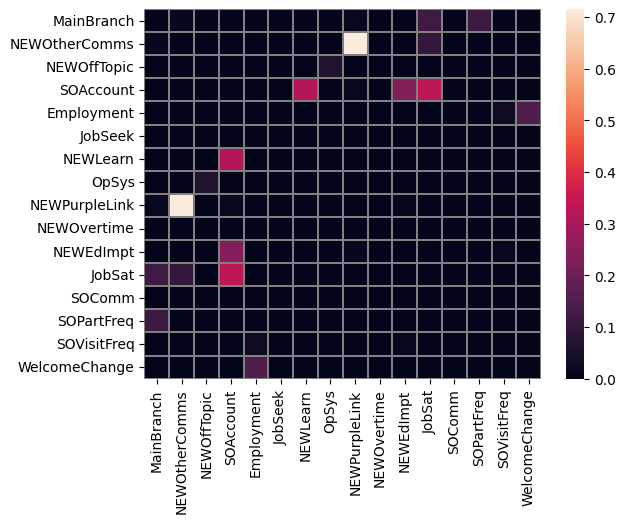

In [11]:
# this code is not filtering right yet
chi_sq_tests_reduced = chi_sq_tests.filter(items=cat_vars_cols, axis=0)
chi_sq_tests_reduced = chi_sq_tests_reduced.filter(items=cat_vars_cols, axis=1)
sns.heatmap(chi_sq_tests_reduced,  
            linewidths=0.1,
            linecolor='grey')

In [12]:
dfstack = chi_sq_tests_reduced.gt(0.1).stack()
indep_cat_pairs = [*dfstack[dfstack].index]
print(indep_cat_pairs)

[('MainBranch', 'JobSat'), ('MainBranch', 'SOPartFreq'), ('NEWOtherComms', 'NEWPurpleLink'), ('SOAccount', 'NEWLearn'), ('SOAccount', 'NEWEdImpt'), ('SOAccount', 'JobSat'), ('Employment', 'WelcomeChange'), ('NEWLearn', 'SOAccount'), ('NEWPurpleLink', 'NEWOtherComms'), ('NEWEdImpt', 'SOAccount'), ('JobSat', 'MainBranch'), ('JobSat', 'SOAccount'), ('SOPartFreq', 'MainBranch'), ('WelcomeChange', 'Employment')]


Most of these variables have some significant connection to one another, but some are independent of one another. Since we're most likely only to get pairs of independent variables, I've generated a list of tuples containing pairs of independent variables from the heatmap above (using the cutoff $p=0.1$), stored in `indep_cat_pairs`. We'll use that later to find the best categorical variables for our model.

### Numerical variable selection

Now we can take a look at our numerical variables, and see which ones are correlated with each other. If two variables are significantly correlated, we should not include both. The cutoff I chose is $r = 0.6$; correlations higher than that are deemed significant, with ones lower than that insignificant. So let's see what we get:

<Axes: >

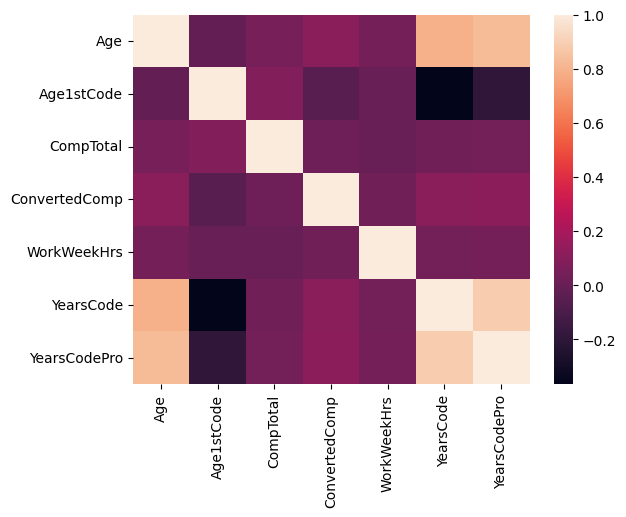

In [13]:
corr_matrix = df[quant_vars_cols].corr(numeric_only=True)
sns.heatmap(corr_matrix)

It looks like `Age` is correlated with `YearsCode` as well as `YearsCodePro` (this seems intuitive). `YearsCode` and `YearsCodePro` are correlated with each other too, so we should only choose one of the three. So I've stored these three in a list to use later for variable selection.

In [14]:
extra_quant_vars = ['Age', 'YearsCode', 'YearsCodePro']
quant_vars_cols = quant_vars_cols.drop(extra_quant_vars)  # keeping quant_vars_cols to only the ones we can always use


`CompTotal` is the total compensation in the survey-taker's native currency, whereas `ConvertedComp` is the salary in USD (using the exchange rate at the time of the survey and 50 working weeks in a year). So `CompTotal` is redundant, if not useless on its own across several currencies. So we'll drop that one.

In [15]:
quant_vars_cols = quant_vars_cols.drop(['CompTotal'])

## Model Building

### Check for imbalance in target variable

We should probably check for imbalance in the target variable (`Hobbyist`) before we get too much further. Let's see how our data is on that front:

Yes    22995
No      6898
Name: Hobbyist, dtype: int64

No's percent of target: 23.1%
Yes/No ratio: 3.334


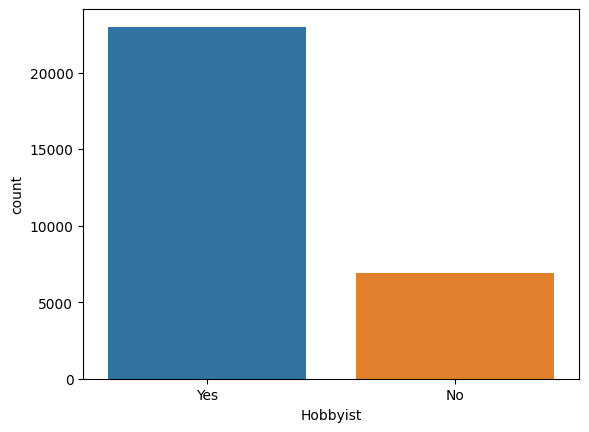

In [16]:
y_n_vals = df.Hobbyist.value_counts()
sns.countplot(df, x='Hobbyist')

print(y_n_vals)

y_n_ratio = y_n_vals.iloc[0]/y_n_vals.iloc[1]
print("\nNo's percent of target: {:.1f}%".format(100*y_n_vals.iloc[1]/df.Hobbyist.count()))
print("Yes/No ratio: {:.3f}".format(y_n_ratio))

So there is some imbalance, but it is relatively mild for this dataset (23% minor class, or less than 4:1 major/minor). Further, for logistic regression, balance is less of an issue than having proper sample sizes for each class, which we do, even for the smaller 'no' class ($n_\text{no}=6898$). So we probably have an accurate representation of the distribution of each. In light of that, we won't worry about applying serious imbalanced learning methods to this data; we will simply used weighted logistic regression. 

Logistic regression, our natural choice for a classification problem with numeric inputs, also accounts for differing scales in input variables with the way coefficients are calculated, so no scaling of the data will be used.

### Final variable selection and model building 

Now we can try out all combinations of variables that aren't correlated with each other, to see which one gives the best $F_1$ score. From there, we'll use a grid search to tune the parameters. 

In [17]:
# works best if this is run only once
df['Hobbyist'] = df['Hobbyist'].map({'Yes': 1, 'No': 0})

In [27]:
# We're using different columns of the data for each fit, so we have to split the whole dataset
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

pipeline = Pipeline([
    ('preprocessor', OneHotEncoder(handle_unknown="ignore")),
    ('classifier', LogisticRegression(random_state=42, 
                                      max_iter=500, 
                                      # adds weights to Y data so that larger class is comparably sized to smaller class
                                      class_weight='balanced'))   
])

It looks like this model has a slightly higher pseudo $R^2$ value, and it looks like we can take out some insignificant featues, we will try taking out these ones: `C(JobSat)[T.Slightly dissatisfied]`,  `C(JobSat)[T.Slightly satisfied]`, `ConvertedComp`. These have the highest p-values by far, there are two others (`C(JobSat)[T.Very dissatisfied]` and `WorkWeekHrs`) that may be considered insignificant, we will remove those later to see how it changes things.

In [24]:
f1_result_list = []

for extra_quant, cat_pair in zip(extra_quant_vars, indep_cat_pairs):
    x_var_cols = quant_vars_cols.append(pd.Index([extra_quant, cat_pair[0], cat_pair[1]]))
    pipeline.fit(train_data[x_var_cols], train_data['Hobbyist'])

    y_preds = pipeline.predict(test_data[x_var_cols])
    f1_score_test = f1_score(test_data['Hobbyist'], y_preds)
    
    f1_result_list.append([",".join(x_var_cols), f1_score_test])                 # store x_var_cols list as single string


f1_result_df = pd.DataFrame(f1_result_list, columns=['Variables', 'R-squared'])  # converting for ease of searching
best_row = f1_result_df['R-squared'].idxmax()
best_x_vars = f1_result_df.loc[best_row, 'Variables']
best_f1 = f1_result_df.loc[best_row, 'R-squared']
best_x_vars = best_x_vars.split(",")
print("Best X varibles:", best_x_vars)
print(f"Best F1 score:   {best_f1:.3}")

Best X varibles: ['Age1stCode', 'ConvertedComp', 'WorkWeekHrs', 'YearsCodePro', 'NEWOtherComms', 'NEWPurpleLink']
Best F1 score:   0.728


Lets take a look at a different model to see if the results change, this time the glm model.

In [33]:
formula = "Hobbyist~C(NEWOtherComms)+C(JobSat)+Age1stCode+ConvertedComp+WorkWeekHrs+YearsCodePro"
formula_best = "Hobbyist ~ " + " + ".join(best_x_vars[0:3]) + " + C(" + best_x_vars[4] + ") + C(" + best_x_vars[5] + ")"

model = smf.glm(formula=formula, data=train_data, family=sm.families.Binomial())
model_best_x = smf.glm(formula=formula_best, data=train_data, family=sm.families.Binomial())

result = model.fit()
result_best_x = model_best_x.fit()

print(result.summary())
print(result_best_x.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Hobbyist   No. Observations:                20843
Model:                            GLM   Df Residuals:                    20833
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10917.
Date:                Wed, 17 Apr 2024   Deviance:                       21833.
Time:                        23:21:52   Pearson chi2:                 2.07e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.03471
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [28]:
param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),
    'classifier__solver': ['lbfgs', 'liblinear']
}

cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(pipeline, 
                           param_grid, 
                           cv=cv, 
                           scoring='accuracy', 
                           n_jobs=-1)

x_train = train_data[best_x_vars]
y_train = train_data['Hobbyist']
x_test = test_data[best_x_vars]
y_test = test_data['Hobbyist']

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(x_test)
y_pred_train = best_model.predict(x_train)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
error_rate_train = 1 - accuracy_train
error_rate_test = 1 - accuracy_test
f1_score_test = f1_score(y_test, y_pred_test, pos_label=1)  # relabeling of Y already done earlier

conf_matrix = confusion_matrix(y_test, y_pred_test)

print(f"\nTrain Accuracy: {accuracy_train*100:.2f}%")
print(f"Test Accuracy: {accuracy_test*100:.2f}%")
print(f"Train Error Rate: {error_rate_train*100:.2f}%")
print(f"Test Error Rate: {error_rate_test*100:.2f}%")
print(f"Test F1 Score: {f1_score_test:.2f}")

print(classification_report(y_test, y_pred_test))

conf_matrix

/Users/martinreid/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/martinreid/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo


Train Accuracy: 73.26%
Test Accuracy: 63.46%
Train Error Rate: 26.74%
Test Error Rate: 36.54%
Test F1 Score: 0.75
              precision    recall  f1-score   support

           0       0.30      0.44      0.35      2045
           1       0.81      0.69      0.75      6923

    accuracy                           0.63      8968
   macro avg       0.55      0.57      0.55      8968
weighted avg       0.69      0.63      0.66      8968



array([[ 897, 1148],
       [2129, 4794]])